In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyrotd
import glob

In [2]:
files = glob.glob("PEERNGARecords_Unscaled_S2/*.A*")

In [3]:
import sys
sys.path.append('./REQPY-master/')
from REQPY_Module import REQPY_single, load_PEERNGA_record

In [4]:
ground_motions = {}
for fname in files:
    eq_id = fname.split('/')[-1].split('_')[0]
    if not(eq_id in ground_motions.keys()):
        ground_motions[eq_id] = {'Name':None, 'Date':None, 'Station':None, 'time_step':None, 'Comp':{}}
    with open(fname) as fp:
        next(fp)
        meta01 = next(fp).strip().split(',')
        ground_motions[eq_id]['Name'] = meta01[0].strip()
        ground_motions[eq_id]['Date'] = meta01[1].strip()
        ground_motions[eq_id]['Station'] = meta01[2].strip()
        next(fp)
        ground_motions[eq_id]['time_step'] = float(next(fp)[17:25])
        ground_motions[eq_id]['Comp'][meta01[3]] = np.array([p for l in fp for p in l.split()]).astype(float)

In [5]:
len(ground_motions)

31

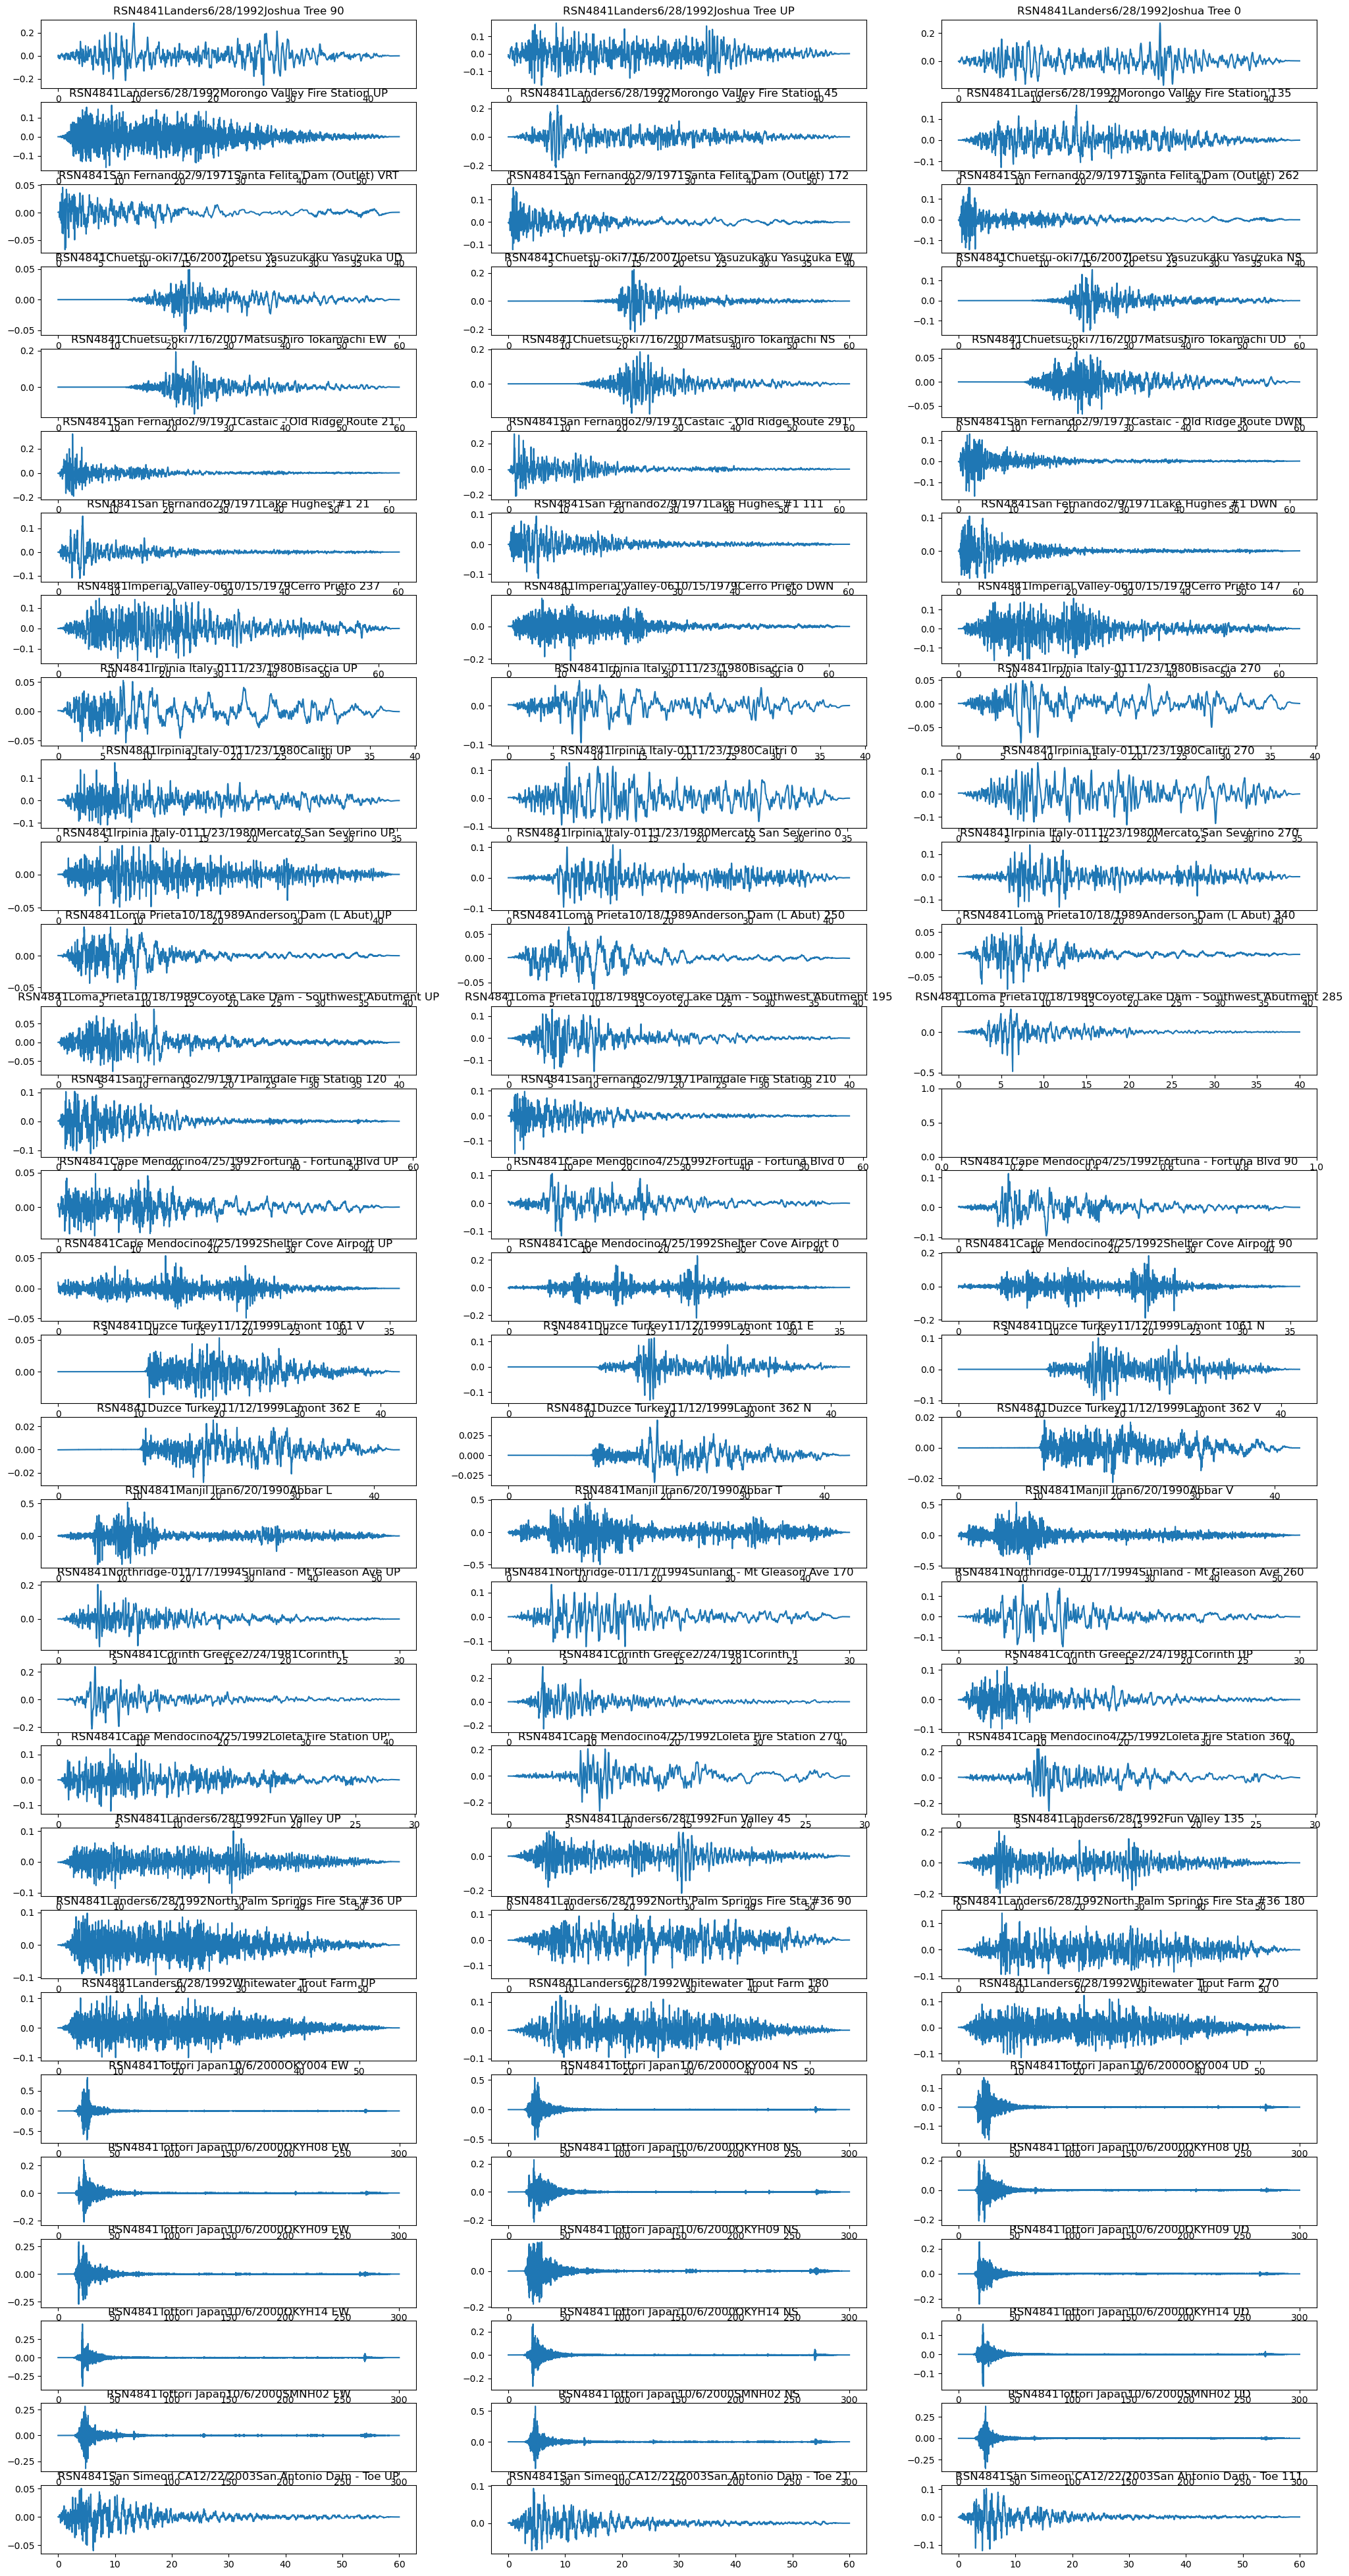

In [6]:
fig, ax = plt.subplots(nrows=31, ncols=3, figsize=(25,50))
i = 0
for eqid, data in ground_motions.items():
    j = 0
    for cmp,th in data['Comp'].items():
        time = np.arange(len(th))*data['time_step']
        ax[i,j].plot(time,th)
        ax[i,j].set_title(eq_id+data['Name']+data['Date']+data['Station']+cmp)
        j  = j+1
    i = i + 1
plt.savefig('th_all.pdf')

In [7]:
for eqid, data in ground_motions.items():
    for cmp in [' UP',' VRT',' UD',' DWN',' V',' UD']:
        if cmp in data['Comp'].keys():
            del ground_motions[eqid]['Comp'][cmp]

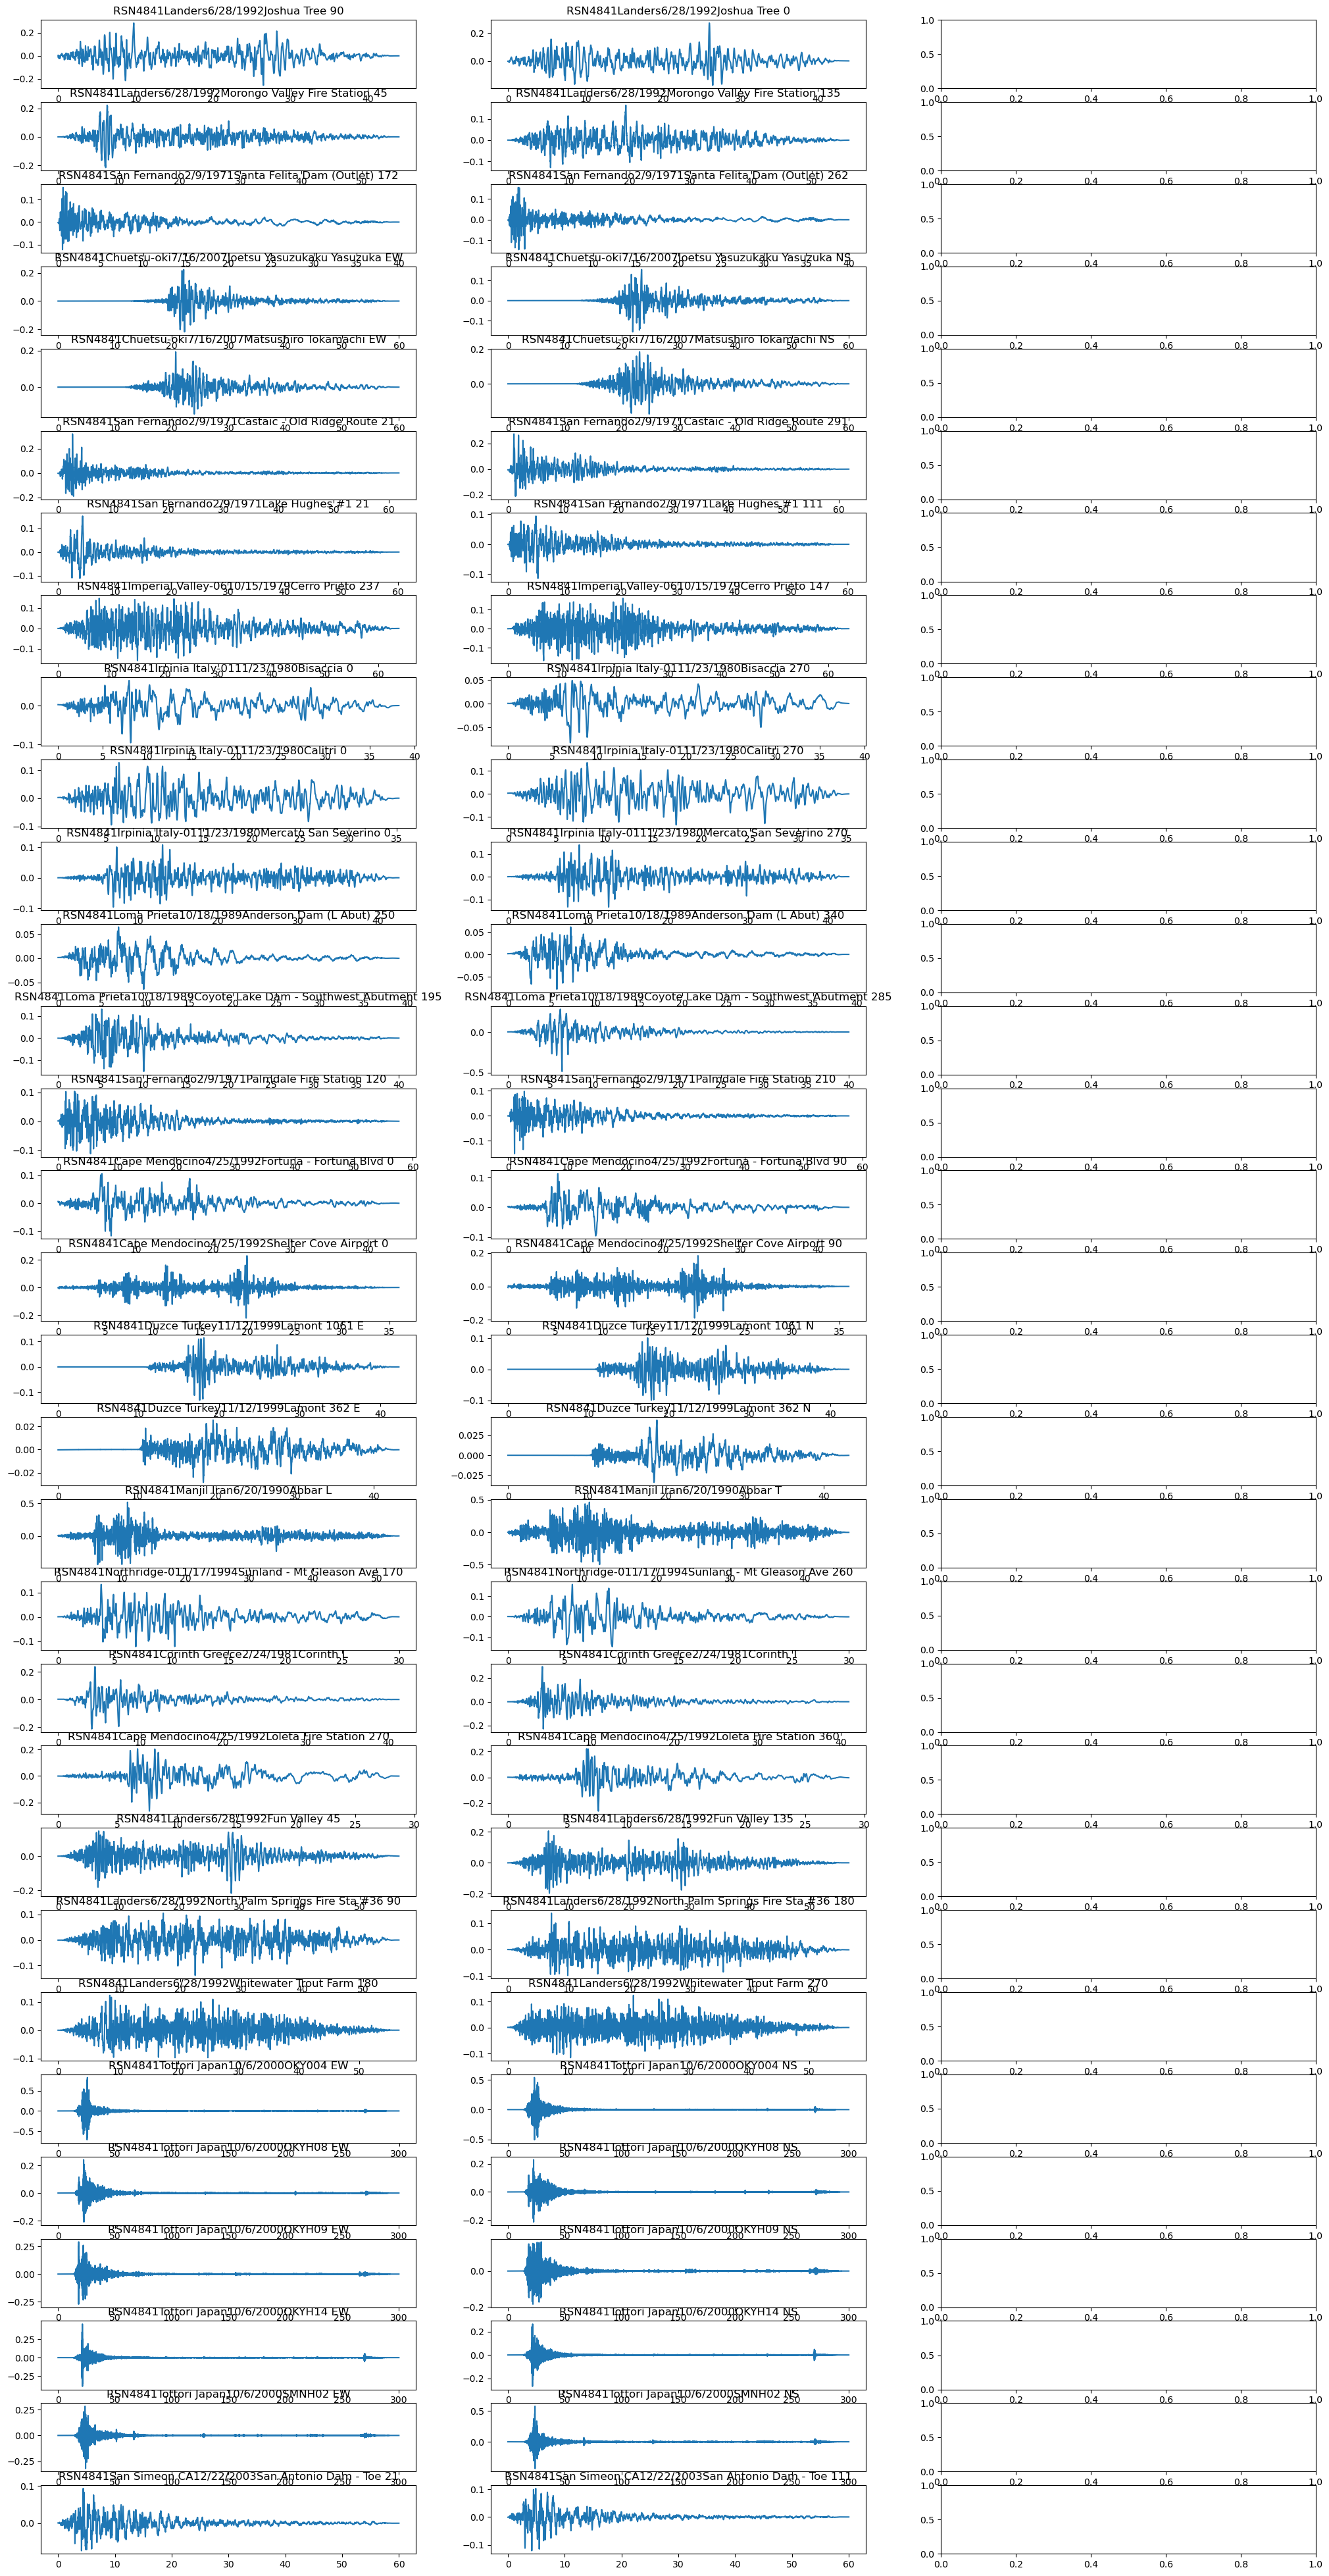

In [8]:
fig, ax = plt.subplots(nrows=31, ncols=3, figsize=(25,50))
i = 0
for eqid, data in ground_motions.items():
    j = 0
    for cmp,th in data['Comp'].items():
        time = np.arange(len(th))*data['time_step']
        ax[i,j].plot(time,th)
        ax[i,j].set_title(eq_id+data['Name']+data['Date']+data['Station']+cmp)
        j  = j+1
    i = i + 1
plt.savefig('th_all.pdf')

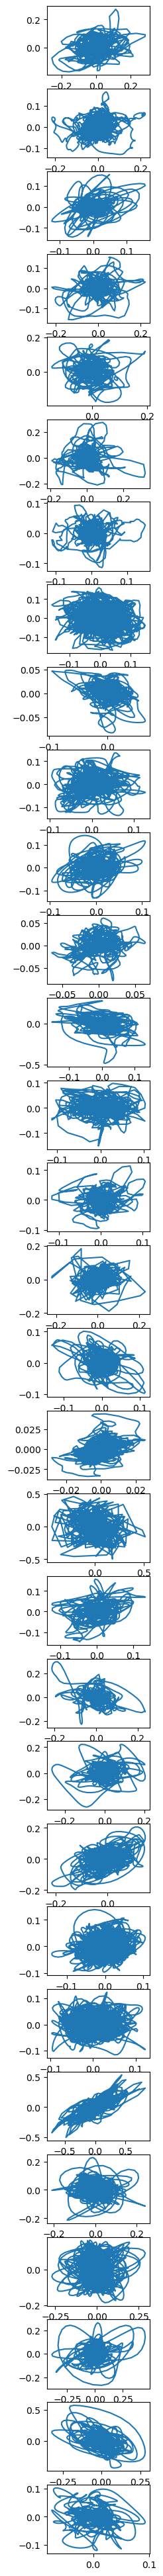

In [9]:
fig, ax = plt.subplots(nrows=31, ncols=1, figsize=(2,50))
i = 0
for eqid, data in ground_motions.items():
    aa = list(data['Comp'].keys())
    ss = min(len(data['Comp'][aa[0]]),len(data['Comp'][aa[1]]))
    ax[i].plot(data['Comp'][aa[0]][:ss],data['Comp'][aa[1]][:ss])
    i = i + 1
plt.savefig('th_all2.pdf')

In [10]:
def read_peer_record(file):
    with open(file) as f:
        f.readline()
        f.readline()
        f.readline()
        dt = np.float(f.readline().split(',')[1].split('=')[1][:9])
        data = []
        for line in f:
            for val in line.strip().split():
                data.append(float(val))
        return dt , np.array(data)

In [11]:
template = open('AbaqusInpFiles/template.inp','r').readlines()
template_str = ''
for line in template:
    template_str = template_str + line

In [12]:
coda_duration = 10 #second
cpu = 10
batfile = 'AbaqusInpFiles/run.bat'
subm_fmt = 'abq2023 input={0:s}.inp job={0:s} cpus={1:d} mp_mode=threads\n'
bat_file = open(batfile,'w')
for eqid, data in ground_motions.items():
    JobName = '{0:s}_{1:s}.inp'.format(eqid,data['Name'].strip())
    inp_fname = 'AbaqusInpFiles/{0:s}_{1:s}.inp'.format(eqid,data['Name'].strip())
    bat_file.write(subm_fmt.format(inp_fname.split('/')[-1][:-4],cpu))
    with open(inp_fname,'w') as f:
        th_key = list(ground_motions[eqid]['Comp'].keys())
        th_str1 = ''
        for j,dd in enumerate(ground_motions[eqid]['Comp'][th_key[0]]):
            if (j%4 == 0):
                th_str1 = th_str1 + '\n{0:15.8f},{1:15.8f}'.format(j*ground_motions[eqid]['time_step'],dd)
            else:
                th_str1 = th_str1 + ',{0:15.8f},{1:15.8f}'.format(j*ground_motions[eqid]['time_step'],dd)
        th_str2 = ''
        for j,dd in enumerate(ground_motions[eqid]['Comp'][th_key[1]]):
            if (j%4 == 0):
                th_str2 = th_str2 + '\n{0:15.8f},{1:15.8f}'.format(j*ground_motions[eqid]['time_step'],dd)
            else:
                th_str2 = th_str2 + ',{0:15.8f},{1:15.8f}'.format(j*ground_motions[eqid]['time_step'],dd)
        DT = ground_motions[eqid]['time_step']
        DUR = j*ground_motions[eqid]['time_step']
        f.write(template_str.format('X_DIR',th_str1[1:-1],\
                'Y_DIR',th_str2[1:-1],\
                DT,DUR+coda_duration,JobName[:-4]))
bat_file.close()

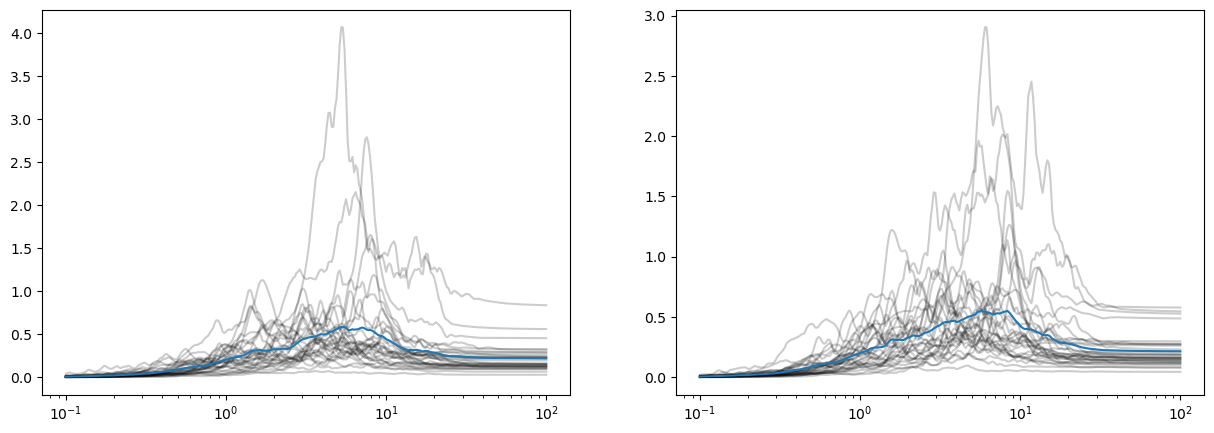

In [13]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
freq = 10**(np.linspace(-1,2, 301))
xdir_avg = np.zeros(301)
ydir_avg = np.zeros(301)
for eqid, data in ground_motions.items():
    th_key = list(ground_motions[eqid]['Comp'].keys())
    resp_spec_x = pyrotd.calc_spec_accels(ground_motions[eqid]['time_step'], ground_motions[eqid]['Comp'][th_key[0]],\
                                          freq, osc_damping=0.05, max_freq_ratio=5, osc_type='psa')
    resp_spec_y = pyrotd.calc_spec_accels(ground_motions[eqid]['time_step'], ground_motions[eqid]['Comp'][th_key[1]],\
                                          freq, osc_damping=0.05, max_freq_ratio=5, osc_type='psa')
    xdir_avg = xdir_avg + resp_spec_x['spec_accel']/31
    ydir_avg = ydir_avg + resp_spec_y['spec_accel']/31
    ax[0].semilogx(freq, resp_spec_x['spec_accel'], c='k', alpha=0.2)
    ax[1].semilogx(freq, resp_spec_y['spec_accel'], c='k', alpha=0.2)
ax[0].semilogx(freq, xdir_avg)
ax[1].semilogx(freq, ydir_avg)

limitations in the seed record
the target spectra can only be matched from 0.04 s
Wavelet decomposition performed
Detail functions generated
Now performing iteration 1 of 50
Now performing iteration 2 of 50
Now performing iteration 3 of 50
Now performing iteration 4 of 50
Now performing iteration 5 of 50
Now performing iteration 6 of 50
Now performing iteration 7 of 50
Now performing iteration 8 of 50
Now performing iteration 9 of 50
Now performing iteration 10 of 50
Now performing iteration 11 of 50
Now performing iteration 12 of 50
Now performing iteration 13 of 50
Now performing iteration 14 of 50
Now performing iteration 15 of 50
Now performing iteration 16 of 50
Now performing iteration 17 of 50
Now performing iteration 18 of 50
Now performing iteration 19 of 50
Now performing iteration 20 of 50
Now performing iteration 21 of 50
Now performing iteration 22 of 50
Now performing iteration 23 of 50
Now performing iteration 24 of 50
Now performing iteration 25 of 50
Now performing ite

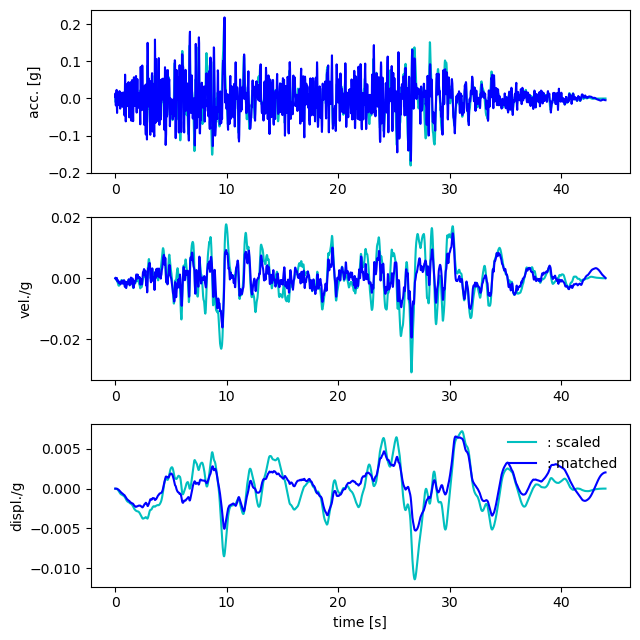

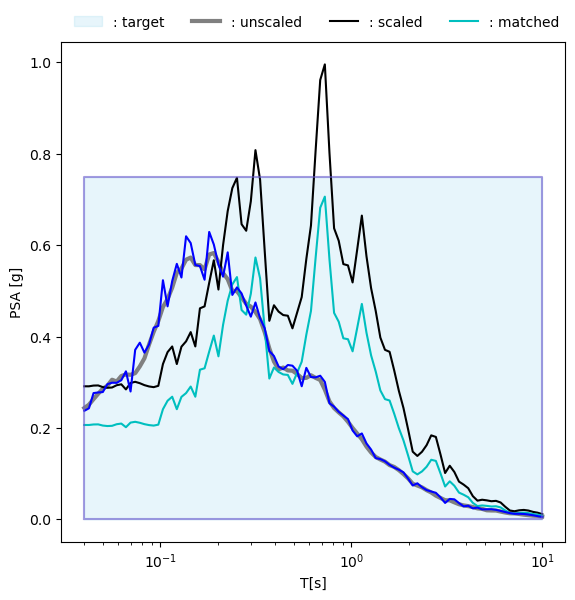

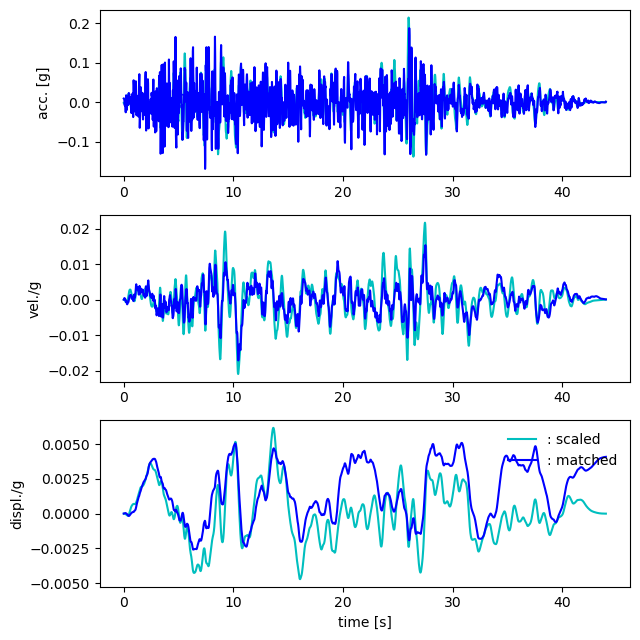

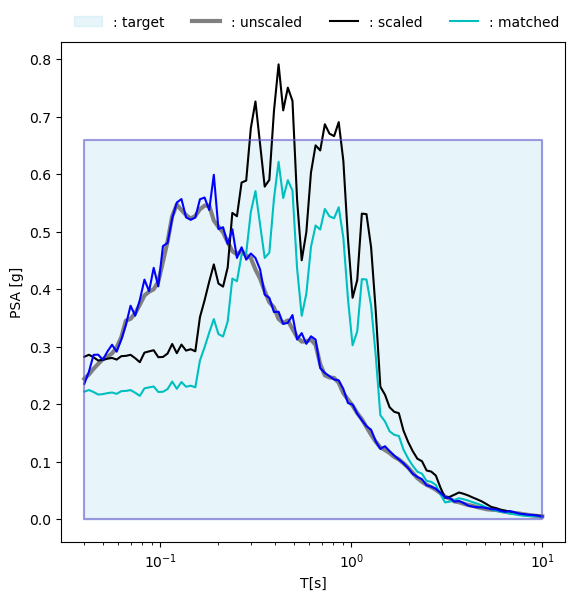

In [14]:
comp_time_histories = {}
dampratio = 0.05                              # damping ratio for spectra
TL1 = 0.01; TL2 = 10
#To = target_psa[:,0]              # original target spectrum periods
#dso = target_psa[:,1]             # original target spectrum psa
for eqid, data in ground_motions.items():
    th_key = list(ground_motions[eqid]['Comp'].keys())
    fs = 1/ground_motions[eqid]['time_step']
    ccs_x,rms,misfit,cvel,cdespl,PSAccs,PSAs,T,sf = REQPY_single(ground_motions[eqid]['Comp'][th_key[0]],fs,np.flip(xdir_avg),1/np.flip(freq),
                                                    T1=TL1,T2=TL2,zi=dampratio,
                                                    nit=50,NS=100,
                                                    baseline=1,plots=1)
    ccs_y,rms,misfit,cvel,cdespl,PSAccs,PSAs,T,sf = REQPY_single(ground_motions[eqid]['Comp'][th_key[1]],fs,np.flip(ydir_avg),1/np.flip(freq),
                                                    T1=TL1,T2=TL2,zi=dampratio,
                                                    nit=50,NS=100,
                                                    baseline=1,plots=1)
    break

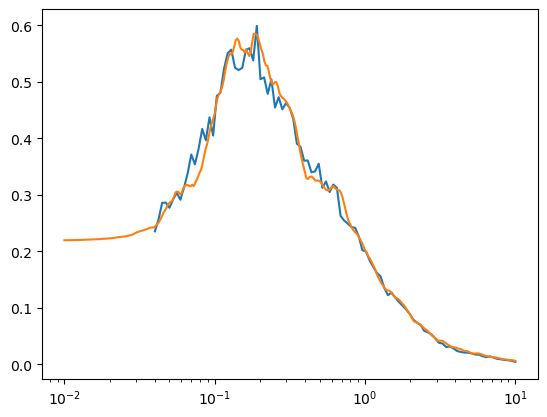

In [15]:
plt.semilogx(T,PSAccs)
plt.plot(1/np.flip(freq), np.flip(xdir_avg))

In [17]:
xdir_str = ''
ydir_str = ''
for i in range(301):
    xdir_str = xdir_str + '{0:15.8f}  {1:15.8f}\n'.format(freq[i], xdir_avg[i])
    ydir_str = ydir_str + '{0:15.8f}  {1:15.8f}\n'.format(freq[i], ydir_avg[i])
with open('xdir_str.RS', 'w') as f:
    f.write(xdir_str)
with open('ydir_str.RS', 'w') as f:
    f.write(ydir_str)